# Dockless Scooter Data

In [2]:
import matplotlib, shapely, geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, datetime
import math
from sklearn.linear_model import LinearRegression

In [5]:
tract_to_name = {
    '000204': "Triangle",
    '000500': "North Campus",
    '000700': "South Campus",
    '000401': "East Campus",
    '000604': "Lower West Campus",
    '000603': "Upper West Campus",
    '000601': "Campus"
}

tract_to_index = {
    '000204': 0,
    '000500': 1,
    '000700': 2,
    '000401': 3,
    '000604': 4,
    '000603': 5,
    '000601': 6,
}

oncampus  = ['000601']
offcampus = ['000204', '000500', '000700', '000401', '000604', '000603']

In [4]:
scooter_data = pd.read_csv('../data/Dockless_Vehicle_Trips.csv')
austin_data = austin = geopandas.GeoDataFrame.from_file('../data/census_tracts_2010_msa/census_tracts_2010_msa.shp')
scooter_data.shape

(4561813, 16)

Dropping the first 6 digits of the tract start and end ids and converting to a numerical type.

In [7]:
scooter_data = scooter_data.dropna(subset=['Census Tract Start'])
                                   
scooter_data.sample(5)

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End
2833058,24ad64a5-e344-48e0-a9e0-9927e7d1a30d,c51e718d-2245-43aa-bc30-9d4c549f2ea3,scooter,2226.0,3764.0,04/07/2019 05:45:00 PM,04/07/2019 06:30:00 PM,04/17/2019 02:10:33 AM,4.0,17.0,0.0,9.0,9.0,2019.0,48453001100,48453001100
2055073,594fa447-dd38-464e-9f75-043d161fe9ad,b726392a-fc2f-4b44-8158-f1bad78711af,scooter,218.0,989.0,02/20/2019 07:00:00 AM,02/20/2019 07:00:00 AM,04/17/2019 05:04:41 AM,2.0,7.0,3.0,9.0,9.0,2019.0,48453000500,48453000500
1837217,7f111511-958d-4eea-9ec1-1b0a67c3f4e4,e8147731-c215-4c06-ba23-212a574f57b6,scooter,366.0,959.0,03/26/2019 09:00:00 PM,03/26/2019 09:00:00 PM,04/17/2019 08:35:06 AM,3.0,21.0,2.0,9.0,9.0,2019.0,48453000603,48453000601
1881365,d71f4a73-aba8-4523-bcbb-342fa05145b3,a528f1af-47f6-4647-93f4-efc9a1a413be,scooter,484.0,2060.0,12/17/2018 09:00:00 AM,12/17/2018 09:15:00 AM,04/17/2019 02:15:22 AM,12.0,9.0,1.0,9.0,9.0,2018.0,48453000402,48453000601
1092314,6c1ace4b-7898-4279-9755-a03f86efe5de,e8993d57-dd12-4ad8-9ea1-6f4fde5b515b,scooter,2347.0,1479.0,03/10/2019 08:15:00 PM,03/10/2019 08:45:00 PM,04/17/2019 02:01:49 PM,3.0,20.0,0.0,9.0,9.0,2019.0,48453001305,48453001305


In [8]:
scooter_data = scooter_data[scooter_data['Census Tract Start'] != 'OUT_OF_BOUNDS']
scooter_data = scooter_data[scooter_data['Census Tract End'] != 'OUT_OF_BOUNDS']
scooter_data['Census Tract Start'] = pd.to_numeric(scooter_data['Census Tract Start'])
scooter_data['Census Tract End'] = pd.to_numeric(scooter_data['Census Tract End'])

In [9]:
def tract_to_trunk(tract):
    return "%06d" % (int(tract) % 1000000)

scooter_data['tract_start'] = scooter_data['Census Tract Start'].apply(tract_to_trunk)
scooter_data['tract_end'] = scooter_data['Census Tract End'].apply(tract_to_trunk)

In [253]:

scooter_data_starting = scooter_data[scooter_data['tract_start'].isin(oncampus + offcampus)]
scooter_data_ending   = scooter_data[scooter_data['tract_end'].isin(oncampus + offcampus)]

In [11]:
scooter_data_raw = pd.read_csv('../data/Dockless_Vehicle_Trips.csv')
scooter_data_raw.shape

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4561813, 16)

In [12]:
100 * (scooter_data_starting.shape[0] / scooter_data_raw.shape[0])

31.847052915145795

In [13]:
start_freqs = scooter_data_starting.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
start_data = geopandas.GeoDataFrame(pd.merge(start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
start_data.head()

,tract_start,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,24339,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,111638,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,43637,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,506146,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,342530,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


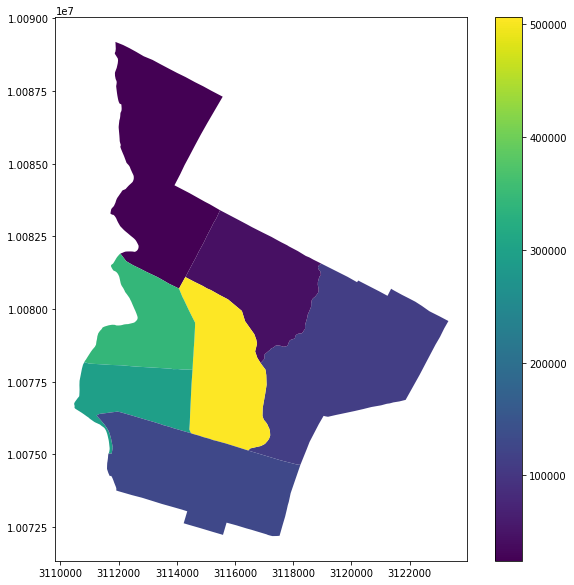

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
start_data.plot(column='count', ax=ax, legend=True)

In [15]:
end_freqs = scooter_data_ending.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()
end_data = geopandas.GeoDataFrame(pd.merge(end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))
end_data.head()

,tract_end,count,TRACTCE10,SUM_totpop,SUM_white,SUM_black,SUM_hispan,SUM_asian,SUM_other,SUM_multi,...,SUM_AGE651,SUM_AGE_65,SUM_AGE75_,SUM_AGE80_,SUM_AGE_85,SUM_FAMSWC,SUM_POP_IN,SUM_FAMILI,SUM_NONFAM,geometry
0,000204,25858,000204,3009.0,2396.0,43.0,323.0,161.0,8.0,78.0,...,21.0,80.0,27.0,20.0,26.0,234.0,56.0,495.0,1101.0,"POLYGON ((3114760.420262146 10081981.02697965,..."
1,000401,119443,000401,3574.0,2446.0,128.0,445.0,439.0,14.0,102.0,...,26.0,86.0,24.0,19.0,19.0,159.0,195.0,442.0,1288.0,"POLYGON ((3119875.384202184 10081103.12966995,..."
2,000500,45669,000500,4518.0,3305.0,67.0,545.0,464.0,18.0,119.0,...,37.0,101.0,13.0,11.0,15.0,147.0,77.0,430.0,2110.0,"POLYGON ((3117812.349419988 10078757.10780583,..."
3,000601,547597,000601,9207.0,4491.0,494.0,1972.0,1943.0,12.0,295.0,...,1.0,2.0,0.0,0.0,0.0,11.0,8396.0,44.0,389.0,"POLYGON ((3116530.436981633 10075208.93904213,..."
4,000603,306894,000603,7793.0,5121.0,149.0,972.0,1351.0,22.0,178.0,...,5.0,14.0,2.0,0.0,1.0,17.0,821.0,209.0,3027.0,"POLYGON ((3114630.355919199 10079462.03781622,..."


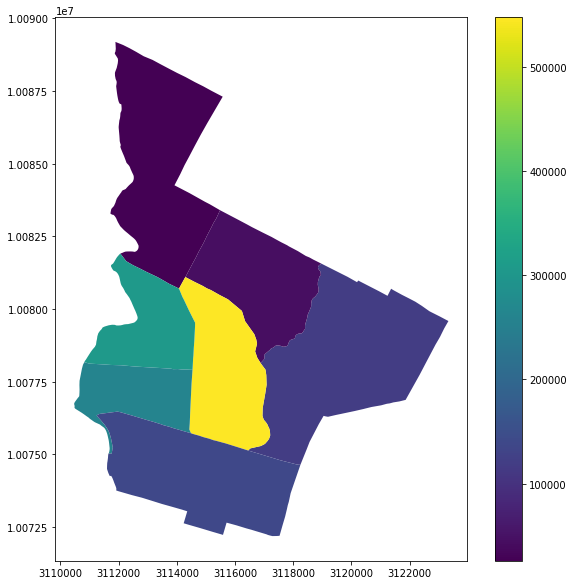

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
end_data.plot(column='count', ax=ax, legend=True)

In [17]:
print(scooter_data_starting.shape, scooter_data_ending.shape)
scooter_data_starting.head()
merged_data =scooter_data_starting[scooter_data_starting['ID'].isin(scooter_data_ending['ID'])]
merged_data.shape

(1452803, 18) (1446243, 18)


(1327537, 18)

In [18]:
merged_start_freqs = merged_data.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
merged_end_freqs = merged_data.groupby(['tract_end'])['tract_end'].agg('count').to_frame('count').reset_index()

merged_start_data = geopandas.GeoDataFrame(pd.merge(merged_start_freqs, austin_data, how='inner', left_on=['tract_start'], right_on=['TRACTCE10']))
merged_end_data = geopandas.GeoDataFrame(pd.merge(merged_end_freqs, austin_data, how='inner', left_on=['tract_end'], right_on=['TRACTCE10']))

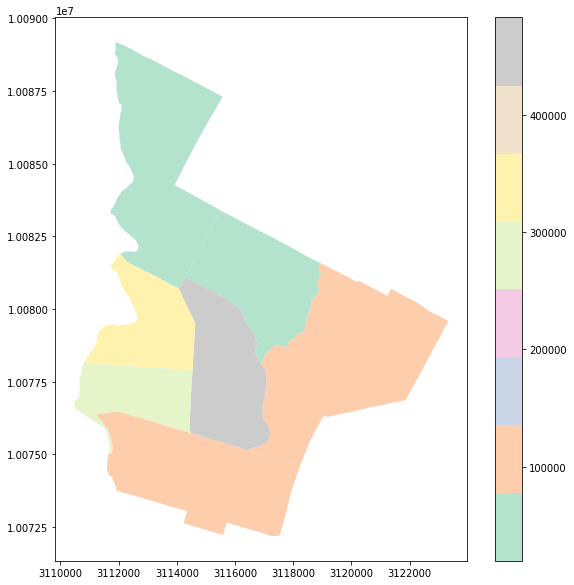

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
merged_start_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

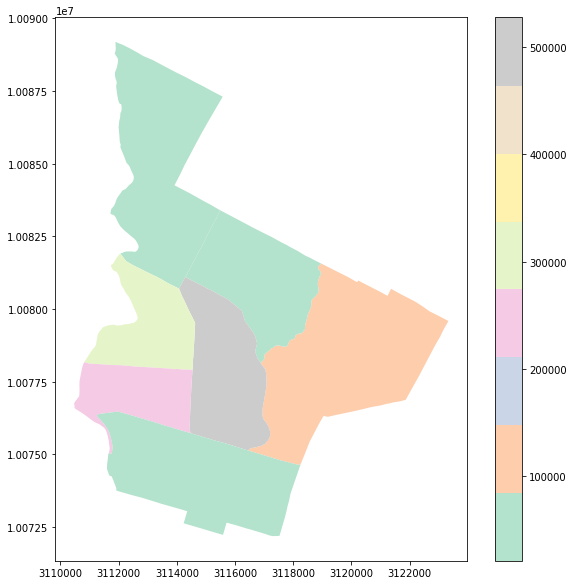

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
merged_end_data.plot(column='count', ax=ax, legend=True, cmap='Pastel2')

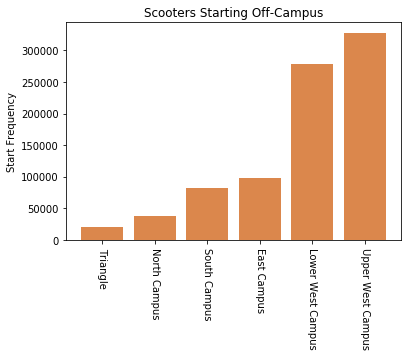

In [21]:
total = 0
d = []
d_norm = []
labels = []
for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    total += freq
    labels.append(tract_to_name[str(loc)])
    d.append(freq)

for loc in offcampus:
    freq = merged_start_freqs[merged_start_freqs["tract_start"] == loc]["count"].iloc[0]
    d_norm.append(freq / total)

plt.bar(labels, d, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Frequencies of Off-Campus Start Locations')

plt.show()

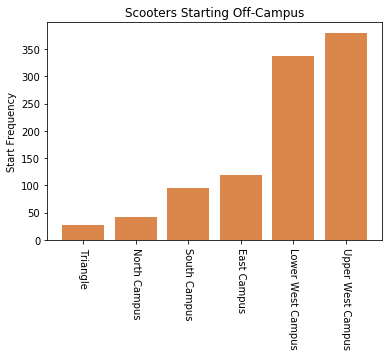

In [22]:
# randomly sample a location :-)
freqqq = [0]*len(offcampus)
for _ in range(1000):
    freqqq[tract_to_index[np.random.choice(offcampus, p=d_norm)]] += 1

plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Frequency')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus')

plt.show()

    Hour  count
14  14.0  10587
16  16.0  10238
15  15.0  10230
    Hour  count
12  12.0  17467
13  13.0  16119
14  14.0  15501
    Hour  count
12  12.0  21069
15  15.0  18788
9    9.0  17597
    Hour  count
12  12.0  19046
13  13.0  17778
14  14.0  17001
    Hour  count
12  12.0  22433
15  15.0  19431
9    9.0  18762
    Hour  count
12  12.0  18290
13  13.0  17581
11  11.0  16597
    Hour  count
16  16.0  14656
15  15.0  14553
14  14.0  14009


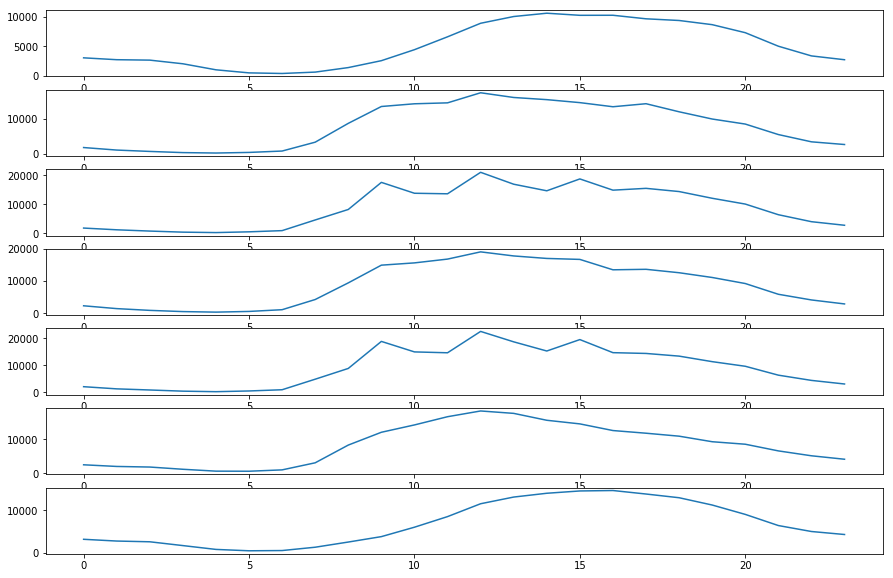

In [23]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['Hour'])['Hour'].agg('count').to_frame('count').reset_index()
    ax[i].plot(time_freq['Hour'], time_freq['count'])
    print(time_freq.nlargest(3, "count"))

In [24]:
merged_data['Start Time'] = pd.to_datetime(merged_data['Start Time'], format="%m/%d/%Y %I:%M:%S %p")
merged_data['End Time']   = pd.to_datetime(merged_data['End Time'],   format="%m/%d/%Y %I:%M:%S %p")

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
merged_data['Start Time'].sample()

30246   2019-04-30 11:00:00
Name: Start Time, dtype: datetime64[ns]

In [26]:
def to_decimal(strtime):
    hour, minute = map(int, strtime.strftime("%H:%M").split(':'))
    return hour + (minute / 60)

merged_data['start_hour_decimal'] = merged_data['Start Time'].apply(to_decimal)
merged_data['end_hour_decimal'] = merged_data['End Time'].apply(to_decimal)

/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/sanjayyepuri/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
merged_data.head()

,ID,Device ID,Vehicle Type,Trip Duration,Trip Distance,Start Time,End Time,Modified Date,Month,Hour,Day of Week,Council District (Start),Council District (End),Year,Census Tract Start,Census Tract End,tract_start,tract_end,start_hour_decimal,end_hour_decimal
2,aa27d854-9f27-456e-ae49-f268a9b2b533,6b90a827-60a1-47ad-94a4-d33654dbd50d,scooter,170.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
3,b7c9f133-966b-46f1-91ce-2682ce7fcf50,1e5234a3-e86b-41e1-a1ad-e98310f3a71c,scooter,90.0,0.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000601,17.5,17.50
5,cd442fb9-058f-46a7-af90-b4adb56fd163,1653cf10-75f5-4934-a9d9-c8d43ade67a9,scooter,438.0,1815.0,2019-04-29 17:30:00,2019-04-29 17:45:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000500,17.5,17.75
7,b7df9ed5-61ae-40ca-9b7e-0ffa1d092b79,09b2c7b8-6631-4999-85d5-4273b4c98f3a,scooter,153.0,0.0,2019-04-29 17:00:00,2019-04-29 17:00:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000604,000604,17.0,17.00
11,7211c488-c0ad-40a9-8a07-4326dbb56c6f,9e6ae0d2-76a0-4e24-8f6e-8d724564b638,scooter,432.0,1698.0,2019-04-29 17:30:00,2019-04-29 17:30:00,04/30/2019 06:45:17 AM,4.0,17.0,1.0,9.0,9.0,2019.0,4.845300e+10,4.845300e+10,000601,000603,17.5,17.50


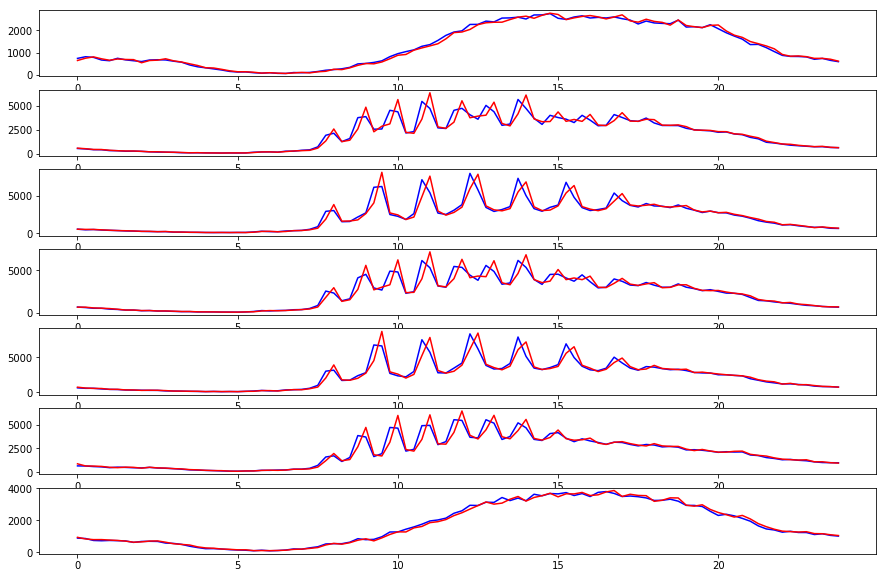

In [28]:
fig, ax = plt.subplots(7, 1,figsize=(15, 10))
for i in range(7): # 0 = sunday, 6 = saturday
    start_time_freq = merged_data[merged_data['Day of Week'] == i].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    end_time_freq   = merged_data[merged_data['Day of Week'] == i].groupby(['end_hour_decimal'])['end_hour_decimal'].agg('count').to_frame('count').reset_index()
    ax[i].plot(start_time_freq['start_hour_decimal'], start_time_freq['count'], c="blue")
    ax[i].plot(end_time_freq['end_hour_decimal'], end_time_freq['count'], c="red")
#     print(time_freq.nlargest(3, "count"))

In [112]:
# P(start_time)
def get_start_time_distribution(class_time):
    first_time      = class_time - 0.50
    second_time     = class_time - 0.25
    
    start_time_freq = merged_data[merged_data['Day of Week'] == 3].groupby(['start_hour_decimal'])['start_hour_decimal'].agg('count').to_frame('count').reset_index()
    first  = int(start_time_freq[start_time_freq['start_hour_decimal'] == first_time]['count'].iloc[0])
    second = int(start_time_freq[start_time_freq['start_hour_decimal'] == second_time]['count'].iloc[0])
    third  = int(start_time_freq[start_time_freq['start_hour_decimal'] == class_time]['count'].iloc[0])
    
    first_ln, second_ln, third_ln = np.log(first), np.log(second), np.log(third)
    first_piecewise  = LinearRegression().fit(np.array([0,  15]).reshape((-1, 1)), [first,  second])
    second_piecewise = LinearRegression().fit(np.array([15, 30]).reshape((-1, 1)), [second_ln, third_ln])
    
    distribution = {}
    total = 0.0
    for minute in range(0, 30):
        if minute < 15:
            total += first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            total += np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])
            
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            distribution[t] = first_piecewise.predict(np.array([minute]).reshape(1, -1))[0]
        else:
            distribution[t] = np.exp(second_piecewise.predict(np.array([minute]).reshape(1, -1))[0])

        distribution[t] /= total
        
    squished_dist = {first_time: 0.0, second_time: 0.0}
    for minute in range(0, 30):
        t = first_time + (minute / 60)
        if minute < 15:
            squished_dist[first_time] += distribution[t]
        else:
            squished_dist[second_time] += distribution[t]

    return squished_dist
# distribution = get_start_time_distribution(8.0)
# print(distribution)

# distribution = get_start_time_distribution(9.0)
# print(distribution)

In [106]:
# P(distance | start_time)
def get_distance_distribution(start_time):
    distances_given_start = merged_data[merged_data["start_hour_decimal"] == start_time]
    distances_given_start = distances_given_start[(distances_given_start['Trip Distance'] > 50) & (distances_given_start['Trip Distance'] < 2000)].sort_values(by=['Trip Distance'])
    distances_freq = distances_given_start.groupby(['Trip Distance'])['Trip Distance'].agg('count').to_frame('count').reset_index()

    # avg pool/smooth data
    distances_freq_pooled = {}
    total = 0.0
    for mid in range(55, 1996, 10):
        distances_freq_pooled[mid] = 0
        window = distances_freq[distances_freq['Trip Distance'].isin(list(range(mid, mid + 10)))]
        val = window['count'].mean()
        if not math.isnan(val):
            distances_freq_pooled[mid] = val
        total += val

    for mid in range(55, 1996, 10):
        distances_freq_pooled[mid] /= total
        
    return distances_freq_pooled

nan


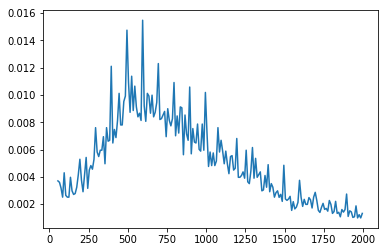

In [71]:
dist = get_distance_distribution(9.0)
x, y = zip(*sorted(dist.items()))

plt.plot(x, y)
plt.show()

In [226]:
from shapely.geometry import Point
from utils import convert_from_lat_long
from endloc_classtime import building_coords

## We will need this data when we implement this for real 
geometries = austin_data[austin_data['TRACTCE10'].isin(tract_to_name.keys())]['geometry']

# offcampus -> oncampus
correct_endpoints_forward = merged_data[merged_data['tract_start'].isin(offcampus)]
correct_endpoints_forward = correct_endpoints_forward[correct_endpoints_forward['tract_end'].isin(oncampus)]

# oncampus -> offcampus
correct_endpoints_backward = merged_data[merged_data['tract_start'].isin(oncampus)]
correct_endpoints_backward = correct_endpoints_backward[correct_endpoints_backward['tract_end'].isin(offcampus)]
correct_endpoints_backward.rename(columns={'tract_start': 'tract_end', 'tract_end': 'tract_start'}, inplace=True)

# all offcampus -> oncampus
correct_endpoints = pd.concat([correct_endpoints_forward, correct_endpoints_backward], sort=False)

# P(start_region | class_location, distance)
def get_start_region_distribution(class_loc, dist):
    global correct_endpoints
    given_distance = correct_endpoints[correct_endpoints['Trip Distance'].isin(range(dist-10, dist+10))]

#     # offcampus -> oncampus
#     correct_endpoints_forward = given_distance[given_distance['tract_start'].isin(offcampus)]
#     correct_endpoints_forward = correct_endpoints_forward[correct_endpoints_forward['tract_end'].isin(oncampus)]

#     # oncampus -> offcampus
#     correct_endpoints_backward = given_distance[given_distance['tract_start'].isin(oncampus)]
#     correct_endpoints_backward = correct_endpoints_backward[correct_endpoints_backward['tract_end'].isin(offcampus)]
#     correct_endpoints_backward.rename(columns={'tract_start': 'tract_end', 'tract_end': 'tract_start'}, inplace=True)

#     # all offcampus -> oncampus
#     correct_endpoints = pd.concat([correct_endpoints_forward, correct_endpoints_backward], sort=False)

#     print(len(correct_endpoints))
    start_tract_freq = given_distance.groupby(['tract_start'])['tract_start'].agg('count').to_frame('count').reset_index()
    
    lat, long = building_coords[class_loc]
    point = Point(lat, long)
    
    total = 0
    distribution = {}
    for i in range(len(start_tract_freq)):
        curr_tract = start_tract_freq.iloc()[i]['tract_start'] # offcampus -> oncampus
            
        geometry = austin_data[austin_data['TRACTCE10'] == str(curr_tract)]['geometry'].iloc()[0]

        if geometry.distance(convert_from_lat_long(point.y, point.x))*0.3048 > dist:   
            distribution[curr_tract] = 5.0
        else:
             distribution[curr_tract] = float(start_tract_freq.iloc()[i]['count'])
        
        total += distribution[curr_tract]
        
    total = float(total)
    
    if total == 0:
        return distribution 
    
    for i in distribution.keys():
        distribution[i] /= total
    
    return distribution

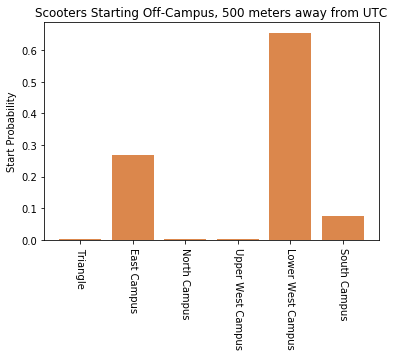

In [144]:
freqqq = []
labels = []
building = 'UTC'
distance = 500
dist = get_start_region_distribution(building, distance)
for tract, prob in dist.items():
    freqqq.append(prob)
    labels.append(tract_to_name[tract])

plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
plt.ylabel('Start Probability')
plt.xticks(rotation=-90)
plt.title('Scooters Starting Off-Campus, %d meters away from %s' % (distance, building))

plt.show()

# plt.bar(labels, freqqq, align='center', color='#cc5500', alpha=0.7)
# plt.ylabel('Start Frequency')
# plt.xticks(rotation=-90)
# plt.title('Scooters Starting Off-Campus')

# plt.show()

In [179]:
def get_building(s):
    return s.split(" ")[0]

class_time_data = pd.read_csv('../data/Course_Info.csv')
class_time_data['building'] = class_time_data['Room'].apply(get_building)
buildings = class_time_data['building'].unique().tolist()
class_time_data = class_time_data.groupby(['Begin Time'])

def to_class_time(hour):
    minute, _ = math.modf(hour)
    return datetime.datetime(2017, 11, 28, int(hour), int(minute * 60), 0, 0).strftime("%I:%M %p").lstrip("0").replace(" 0", " ")

def get_end_location_distribution(class_time_decimal):
    global class_time_data, buildings
    
    class_time = to_class_time(class_time_decimal)
    dist = {b:0 for b in buildings} # dictionary for {class_time : {building : probability_distr}}
        
    df = class_time_data.get_group(class_time)

    df = df.groupby('building')['building'].agg('count').to_frame('count').reset_index()
    total_classes = 0.0
    for i in range(len(df)):
        room = df.iloc()[i]['building']
        count = df.iloc()[i]['count']
        dist[room] = count
        total_classes += count
        
    for key, value in dist.items():
        dist[key] /= total_classes

    return dist

print(get_end_location_distribution(9.5))


{'EER': 0.05405405405405406, 'BUR': 0.02702702702702703, 'UTC': 0.05405405405405406, 'ECJ': 0.05405405405405406, 'CPE': 0.08108108108108109, 'RLM': 0.1891891891891892, 'MEZ': 0.0, 'CBA': 0.05405405405405406, 'GSB': 0.0, 'ART': 0.0, 'ETC': 0.05405405405405406, 'CMA': 0.0, 'RLP': 0.05405405405405406, 'JGB': 0.0, 'PHR': 0.0, 'SZB': 0.0, 'WAG': 0.0, 'PAR': 0.05405405405405406, 'PAI': 0.02702702702702703, 'GDC': 0.08108108108108109, 'FNT': 0.0, 'WMB': 0.05405405405405406, 'GOL': 0.02702702702702703, 'BTL': 0.0, 'SUT': 0.02702702702702703, 'DFA': 0.0, 'SEA': 0.0, 'GAR': 0.05405405405405406, 'CAL': 0.0, 'GEA': 0.0, 'BAT': 0.0, 'BEN': 0.0, 'MRH': 0.05405405405405406}


In [227]:
import time
# naive sampling (slow; ~0.3 seconds/sample)

start = time.time()
class_time = 9
start_time_distribution = get_start_time_distribution(class_time)
end_location_distribution = get_end_location_distribution(class_time)

trips = []
samples = 10
for _ in range(samples):
    # start_time
    start_time = np.random.choice(list(start_time_distribution.keys()), p=list(start_time_distribution.values()))

    # end_location
    end_location = np.random.choice(list(end_location_distribution.keys()), p=list(end_location_distribution.values()))

    # distances
    distance_distribution = get_distance_distribution(start_time)
    distance = np.random.choice(list(distance_distribution.keys()), p=list(distance_distribution.values()))

    # start_region
    start_region_distribution = get_start_region_distribution(end_location, distance)
    start_region = np.random.choice(list(start_region_distribution.keys()), p=list(start_region_distribution.values()))
    
    trips.append((start_region, end_location))

#     print("class at %.2f in %s, start in %s at %.2f and travel %dm" % (class_time, end_location, tract_to_name[start_region], start_time, distance))

print((time.time() - start) / samples)


0.22543008327484132


In [236]:
# gibbs sampling

class_time = 9

# fixed
start_time_distribution = get_start_time_distribution(class_time)
end_location_distribution = get_end_location_distribution(class_time)

# start_time
start_time = np.random.choice(list(start_time_distribution.keys()), p=list(start_time_distribution.values()))

# end_location
end_location = np.random.choice(list(end_location_distribution.keys()), p=list(end_location_distribution.values()))

# distances
distance_distribution = get_distance_distribution(start_time)
distance = np.random.choice(list(distance_distribution.keys()), p=list(distance_distribution.values()))

# start_region
start_region_distribution = get_start_region_distribution(end_location, distance)
start_region = np.random.choice(list(start_region_distribution.keys()), p=list(start_region_distribution.values()))

# pre-compute start_region_distribution
sr_dist = {}
for el in buildings:
    sr_dist[el] = {}
    for d in range(55, 1996, 10):
        sr_dist[el][d] = get_start_region_distribution(el, d)
#         print("on %s %d" % (el, d))

seed = [class_time, start_time, end_location, distance, start_region]

on EER 55
on EER 65
on EER 75
on EER 85
on EER 95
on EER 105
on EER 115
on EER 125
on EER 135
on EER 145
on EER 155
on EER 165
on EER 175
on EER 185
on EER 195
on EER 205
on EER 215
on EER 225
on EER 235
on EER 245
on EER 255
on EER 265
on EER 275
on EER 285
on EER 295
on EER 305
on EER 315
on EER 325
on EER 335
on EER 345
on EER 355
on EER 365
on EER 375
on EER 385
on EER 395
on EER 405
on EER 415
on EER 425
on EER 435
on EER 445
on EER 455
on EER 465
on EER 475
on EER 485
on EER 495
on EER 505
on EER 515
on EER 525
on EER 535
on EER 545
on EER 555
on EER 565
on EER 575
on EER 585
on EER 595
on EER 605
on EER 615
on EER 625
on EER 635
on EER 645
on EER 655
on EER 665
on EER 675
on EER 685
on EER 695
on EER 705
on EER 715
on EER 725
on EER 735
on EER 745
on EER 755
on EER 765
on EER 775
on EER 785
on EER 795
on EER 805
on EER 815
on EER 825
on EER 835
on EER 845
on EER 855
on EER 865
on EER 875
on EER 885
on EER 895
on EER 905
on EER 915
on EER 925
on EER 935
on EER 945
on EER 955
on E

on ECJ 1415
on ECJ 1425
on ECJ 1435
on ECJ 1445
on ECJ 1455
on ECJ 1465
on ECJ 1475
on ECJ 1485
on ECJ 1495
on ECJ 1505
on ECJ 1515
on ECJ 1525
on ECJ 1535
on ECJ 1545
on ECJ 1555
on ECJ 1565
on ECJ 1575
on ECJ 1585
on ECJ 1595
on ECJ 1605
on ECJ 1615
on ECJ 1625
on ECJ 1635
on ECJ 1645
on ECJ 1655
on ECJ 1665
on ECJ 1675
on ECJ 1685
on ECJ 1695
on ECJ 1705
on ECJ 1715
on ECJ 1725
on ECJ 1735
on ECJ 1745
on ECJ 1755
on ECJ 1765
on ECJ 1775
on ECJ 1785
on ECJ 1795
on ECJ 1805
on ECJ 1815
on ECJ 1825
on ECJ 1835
on ECJ 1845
on ECJ 1855
on ECJ 1865
on ECJ 1875
on ECJ 1885
on ECJ 1895
on ECJ 1905
on ECJ 1915
on ECJ 1925
on ECJ 1935
on ECJ 1945
on ECJ 1955
on ECJ 1965
on ECJ 1975
on ECJ 1985
on ECJ 1995
on CPE 55
on CPE 65
on CPE 75
on CPE 85
on CPE 95
on CPE 105
on CPE 115
on CPE 125
on CPE 135
on CPE 145
on CPE 155
on CPE 165
on CPE 175
on CPE 185
on CPE 195
on CPE 205
on CPE 215
on CPE 225
on CPE 235
on CPE 245
on CPE 255
on CPE 265
on CPE 275
on CPE 285
on CPE 295
on CPE 305
on CPE 315


on CBA 755
on CBA 765
on CBA 775
on CBA 785
on CBA 795
on CBA 805
on CBA 815
on CBA 825
on CBA 835
on CBA 845
on CBA 855
on CBA 865
on CBA 875
on CBA 885
on CBA 895
on CBA 905
on CBA 915
on CBA 925
on CBA 935
on CBA 945
on CBA 955
on CBA 965
on CBA 975
on CBA 985
on CBA 995
on CBA 1005
on CBA 1015
on CBA 1025
on CBA 1035
on CBA 1045
on CBA 1055
on CBA 1065
on CBA 1075
on CBA 1085
on CBA 1095
on CBA 1105
on CBA 1115
on CBA 1125
on CBA 1135
on CBA 1145
on CBA 1155
on CBA 1165
on CBA 1175
on CBA 1185
on CBA 1195
on CBA 1205
on CBA 1215
on CBA 1225
on CBA 1235
on CBA 1245
on CBA 1255
on CBA 1265
on CBA 1275
on CBA 1285
on CBA 1295
on CBA 1305
on CBA 1315
on CBA 1325
on CBA 1335
on CBA 1345
on CBA 1355
on CBA 1365
on CBA 1375
on CBA 1385
on CBA 1395
on CBA 1405
on CBA 1415
on CBA 1425
on CBA 1435
on CBA 1445
on CBA 1455
on CBA 1465
on CBA 1475
on CBA 1485
on CBA 1495
on CBA 1505
on CBA 1515
on CBA 1525
on CBA 1535
on CBA 1545
on CBA 1555
on CBA 1565
on CBA 1575
on CBA 1585
on CBA 1595
on CB

on CMA 65
on CMA 75
on CMA 85
on CMA 95
on CMA 105
on CMA 115
on CMA 125
on CMA 135
on CMA 145
on CMA 155
on CMA 165
on CMA 175
on CMA 185
on CMA 195
on CMA 205
on CMA 215
on CMA 225
on CMA 235
on CMA 245
on CMA 255
on CMA 265
on CMA 275
on CMA 285
on CMA 295
on CMA 305
on CMA 315
on CMA 325
on CMA 335
on CMA 345
on CMA 355
on CMA 365
on CMA 375
on CMA 385
on CMA 395
on CMA 405
on CMA 415
on CMA 425
on CMA 435
on CMA 445
on CMA 455
on CMA 465
on CMA 475
on CMA 485
on CMA 495
on CMA 505
on CMA 515
on CMA 525
on CMA 535
on CMA 545
on CMA 555
on CMA 565
on CMA 575
on CMA 585
on CMA 595
on CMA 605
on CMA 615
on CMA 625
on CMA 635
on CMA 645
on CMA 655
on CMA 665
on CMA 675
on CMA 685
on CMA 695
on CMA 705
on CMA 715
on CMA 725
on CMA 735
on CMA 745
on CMA 755
on CMA 765
on CMA 775
on CMA 785
on CMA 795
on CMA 805
on CMA 815
on CMA 825
on CMA 835
on CMA 845
on CMA 855
on CMA 865
on CMA 875
on CMA 885
on CMA 895
on CMA 905
on CMA 915
on CMA 925
on CMA 935
on CMA 945
on CMA 955
on CMA 965
on 

on PHR 1415
on PHR 1425
on PHR 1435
on PHR 1445
on PHR 1455
on PHR 1465
on PHR 1475
on PHR 1485
on PHR 1495
on PHR 1505
on PHR 1515
on PHR 1525
on PHR 1535
on PHR 1545
on PHR 1555
on PHR 1565
on PHR 1575
on PHR 1585
on PHR 1595
on PHR 1605
on PHR 1615
on PHR 1625
on PHR 1635
on PHR 1645
on PHR 1655
on PHR 1665
on PHR 1675
on PHR 1685
on PHR 1695
on PHR 1705
on PHR 1715
on PHR 1725
on PHR 1735
on PHR 1745
on PHR 1755
on PHR 1765
on PHR 1775
on PHR 1785
on PHR 1795
on PHR 1805
on PHR 1815
on PHR 1825
on PHR 1835
on PHR 1845
on PHR 1855
on PHR 1865
on PHR 1875
on PHR 1885
on PHR 1895
on PHR 1905
on PHR 1915
on PHR 1925
on PHR 1935
on PHR 1945
on PHR 1955
on PHR 1965
on PHR 1975
on PHR 1985
on PHR 1995
on SZB 55
on SZB 65
on SZB 75
on SZB 85
on SZB 95
on SZB 105
on SZB 115
on SZB 125
on SZB 135
on SZB 145
on SZB 155
on SZB 165
on SZB 175
on SZB 185
on SZB 195
on SZB 205
on SZB 215
on SZB 225
on SZB 235
on SZB 245
on SZB 255
on SZB 265
on SZB 275
on SZB 285
on SZB 295
on SZB 305
on SZB 315


on PAI 755
on PAI 765
on PAI 775
on PAI 785
on PAI 795
on PAI 805
on PAI 815
on PAI 825
on PAI 835
on PAI 845
on PAI 855
on PAI 865
on PAI 875
on PAI 885
on PAI 895
on PAI 905
on PAI 915
on PAI 925
on PAI 935
on PAI 945
on PAI 955
on PAI 965
on PAI 975
on PAI 985
on PAI 995
on PAI 1005
on PAI 1015
on PAI 1025
on PAI 1035
on PAI 1045
on PAI 1055
on PAI 1065
on PAI 1075
on PAI 1085
on PAI 1095
on PAI 1105
on PAI 1115
on PAI 1125
on PAI 1135
on PAI 1145
on PAI 1155
on PAI 1165
on PAI 1175
on PAI 1185
on PAI 1195
on PAI 1205
on PAI 1215
on PAI 1225
on PAI 1235
on PAI 1245
on PAI 1255
on PAI 1265
on PAI 1275
on PAI 1285
on PAI 1295
on PAI 1305
on PAI 1315
on PAI 1325
on PAI 1335
on PAI 1345
on PAI 1355
on PAI 1365
on PAI 1375
on PAI 1385
on PAI 1395
on PAI 1405
on PAI 1415
on PAI 1425
on PAI 1435
on PAI 1445
on PAI 1455
on PAI 1465
on PAI 1475
on PAI 1485
on PAI 1495
on PAI 1505
on PAI 1515
on PAI 1525
on PAI 1535
on PAI 1545
on PAI 1555
on PAI 1565
on PAI 1575
on PAI 1585
on PAI 1595
on PA

on GOL 65
on GOL 75
on GOL 85
on GOL 95
on GOL 105
on GOL 115
on GOL 125
on GOL 135
on GOL 145
on GOL 155
on GOL 165
on GOL 175
on GOL 185
on GOL 195
on GOL 205
on GOL 215
on GOL 225
on GOL 235
on GOL 245
on GOL 255
on GOL 265
on GOL 275
on GOL 285
on GOL 295
on GOL 305
on GOL 315
on GOL 325
on GOL 335
on GOL 345
on GOL 355
on GOL 365
on GOL 375
on GOL 385
on GOL 395
on GOL 405
on GOL 415
on GOL 425
on GOL 435
on GOL 445
on GOL 455
on GOL 465
on GOL 475
on GOL 485
on GOL 495
on GOL 505
on GOL 515
on GOL 525
on GOL 535
on GOL 545
on GOL 555
on GOL 565
on GOL 575
on GOL 585
on GOL 595
on GOL 605
on GOL 615
on GOL 625
on GOL 635
on GOL 645
on GOL 655
on GOL 665
on GOL 675
on GOL 685
on GOL 695
on GOL 705
on GOL 715
on GOL 725
on GOL 735
on GOL 745
on GOL 755
on GOL 765
on GOL 775
on GOL 785
on GOL 795
on GOL 805
on GOL 815
on GOL 825
on GOL 835
on GOL 845
on GOL 855
on GOL 865
on GOL 875
on GOL 885
on GOL 895
on GOL 905
on GOL 915
on GOL 925
on GOL 935
on GOL 945
on GOL 955
on GOL 965
on 

on DFA 1415
on DFA 1425
on DFA 1435
on DFA 1445
on DFA 1455
on DFA 1465
on DFA 1475
on DFA 1485
on DFA 1495
on DFA 1505
on DFA 1515
on DFA 1525
on DFA 1535
on DFA 1545
on DFA 1555
on DFA 1565
on DFA 1575
on DFA 1585
on DFA 1595
on DFA 1605
on DFA 1615
on DFA 1625
on DFA 1635
on DFA 1645
on DFA 1655
on DFA 1665
on DFA 1675
on DFA 1685
on DFA 1695
on DFA 1705
on DFA 1715
on DFA 1725
on DFA 1735
on DFA 1745
on DFA 1755
on DFA 1765
on DFA 1775
on DFA 1785
on DFA 1795
on DFA 1805
on DFA 1815
on DFA 1825
on DFA 1835
on DFA 1845
on DFA 1855
on DFA 1865
on DFA 1875
on DFA 1885
on DFA 1895
on DFA 1905
on DFA 1915
on DFA 1925
on DFA 1935
on DFA 1945
on DFA 1955
on DFA 1965
on DFA 1975
on DFA 1985
on DFA 1995
on SEA 55
on SEA 65
on SEA 75
on SEA 85
on SEA 95
on SEA 105
on SEA 115
on SEA 125
on SEA 135
on SEA 145
on SEA 155
on SEA 165
on SEA 175
on SEA 185
on SEA 195
on SEA 205
on SEA 215
on SEA 225
on SEA 235
on SEA 245
on SEA 255
on SEA 265
on SEA 275
on SEA 285
on SEA 295
on SEA 305
on SEA 315


on GEA 755
on GEA 765
on GEA 775
on GEA 785
on GEA 795
on GEA 805
on GEA 815
on GEA 825
on GEA 835
on GEA 845
on GEA 855
on GEA 865
on GEA 875
on GEA 885
on GEA 895
on GEA 905
on GEA 915
on GEA 925
on GEA 935
on GEA 945
on GEA 955
on GEA 965
on GEA 975
on GEA 985
on GEA 995
on GEA 1005
on GEA 1015
on GEA 1025
on GEA 1035
on GEA 1045
on GEA 1055
on GEA 1065
on GEA 1075
on GEA 1085
on GEA 1095
on GEA 1105
on GEA 1115
on GEA 1125
on GEA 1135
on GEA 1145
on GEA 1155
on GEA 1165
on GEA 1175
on GEA 1185
on GEA 1195
on GEA 1205
on GEA 1215
on GEA 1225
on GEA 1235
on GEA 1245
on GEA 1255
on GEA 1265
on GEA 1275
on GEA 1285
on GEA 1295
on GEA 1305
on GEA 1315
on GEA 1325
on GEA 1335
on GEA 1345
on GEA 1355
on GEA 1365
on GEA 1375
on GEA 1385
on GEA 1395
on GEA 1405
on GEA 1415
on GEA 1425
on GEA 1435
on GEA 1445
on GEA 1455
on GEA 1465
on GEA 1475
on GEA 1485
on GEA 1495
on GEA 1505
on GEA 1515
on GEA 1525
on GEA 1535
on GEA 1545
on GEA 1555
on GEA 1565
on GEA 1575
on GEA 1585
on GEA 1595
on GE

In [246]:
# pre-compute distance_distribution
d_dist = {}
for st in [class_time - 0.25, class_time - 0.5]:
    d_dist[st] = get_distance_distribution(st)

In [252]:
# seed = [ct, st, el, d, sr]
def resample(new_variable, seed):
    if new_variable == 1: # start_time
        dist = {}
        # P[ST | ct] * P[d | ST]
        d = seed[3]
        start_time_distribution = get_start_time_distribution(class_time)
        for st in start_time_distribution.keys():
#             dist[st] = get_distance_distribution(st)[d] * start_time_distribution[st]
            dist[st] = d_dist[st][d] * start_time_distribution[st]
    elif new_variable == 2: # end_location
        dist = {}
        # P[EL | ct] * P[sr | d, EL]
        ct = seed[0]
        d = seed[3]
        sr = seed[4]
        end_location_distribution = get_end_location_distribution(ct)
        for el in end_location_distribution.keys():
#             dist[el] = end_location_distribution[el] * get_start_region_distribution(el, d)[sr]
            dist[el] = end_location_distribution[el] * sr_dist[el][d][sr]
    elif new_variable == 3: # distance
        dist = {}
        # P[D | st] * P[sr | D, el]
        st = seed[1]
        el = seed[2]
        sr = seed[4]
#         distance_distribution = get_distance_distribution(st)
        for d in d_dist[st].keys():
#             dist[d] = distance_distribution[d] * get_start_region_distribution(el, d)[sr]
            dist[d] = d_dist[st][d] * sr_dist[el][d][sr]
    else: # start_region
        # P[SR | d, el]
        el = seed[2]
        d = seed[3]
#         dist = get_start_region_distribution(el, d)
        dist = sr_dist[el][d]
    
    # normalize
    total = sum(list(dist.values()))
    for key, _ in dist.items():
        dist[key] /= total
    
    # return sampled value
    return np.random.choice(list(dist.keys()), p=list(dist.values()))

start = time.time()
trips = []
samples = 100
for _ in range(samples):
    # pick random variable to re-sample
    # class_time is always evidence; never re-sample it
    new_variable = np.random.randint(1, 5)
#     print(resample(new_variable, seed))
    seed[new_variable] = resample(new_variable, seed)
    
    class_time, start_time, end_location, distance, start_region = seed
    print("class at %.2f in %s, start in %s at %.2f and travel %dm" % (class_time, end_location, tract_to_name[start_region], start_time, distance))
    
    trips.append((start_region, end_location))

print((time.time() - start) / samples)

class at 9.00 in RLM, start in Upper West Campus at 8.50 and travel 1095m
class at 9.00 in RLM, start in Upper West Campus at 8.50 and travel 1075m
class at 9.00 in RLM, start in Upper West Campus at 8.75 and travel 1075m
class at 9.00 in RLM, start in Upper West Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in Upper West Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in Upper West Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 1075m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 475m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 345m
class at 9.00 in UTC, start in South Campus at 8.50 and travel 345m
class at 9.00 in UTC, start in South Campus at 8.75 and travel 345m
class at

In [ ]:
# number of end locations = 33
# number distances = 195
# number of start times = 2
# number of start regions = 6
# size of sample space = 77220

# 5000 samples => 386,100,000

In [183]:
# import pomegranate as pm

# class_time = 9

# # P(start_time)
# ST = pm.DiscreteDistribution(get_start_time_distribution(class_time))
# D  = pm.ConditionalProbabilityTable()

In [225]:
correct_endpoints['tract_end'].sample(100)

923489     000601
3326124    000601
1237423    000601
3671970    000601
597026     000601
2553881    000601
4318881    000601
4389816    000601
3852054    000601
797637     000601
1917121    000601
688856     000601
1741991    000601
4357590    000601
149176     000601
4114107    000601
3278170    000601
2090235    000601
617928     000601
2783673    000601
2862848    000601
3849106    000601
112958     000601
2431416    000601
1144878    000601
1999553    000601
3680115    000601
3082567    000601
1343995    000601
709905     000601
            ...  
3560569    000601
848541     000601
1325975    000601
435114     000601
535052     000601
347788     000601
420746     000601
257881     000601
1155595    000601
748854     000601
4486389    000601
983186     000601
100367     000601
2583084    000601
3835386    000601
208103     000601
2508776    000601
2640215    000601
2720632    000601
1305785    000601
869902     000601
71816      000601
644062     000601
10375      000601
3667524   

In [233]:
a ={}
a["hi"] = {}